<a href="https://colab.research.google.com/github/d-roland/Fake-news-detection/blob/master/CS221_Fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [73]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import csv
from collections import Counter, defaultdict
from wordcloud import WordCloud
import nltk
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
import gensim
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
from datetime import datetime
from statistics import mean

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Gathering data**

## Integrating BuzzFeed Real News

In [4]:
bfreal = pd.read_csv('/content/drive/My Drive/CS221_Project/BuzzFeed_real_news_content.csv')
bfreal.shape

(91, 12)

In [5]:
bfreal.head()

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data
0,Real_1-Webpage,Another Terrorist Attack in NYC…Why Are we STI...,"On Saturday, September 17 at 8:30 pm EST, an e...",http://eaglerising.com/36942/another-terrorist...,http://eaglerising.com/wp-content/uploads/2016...,"View All Posts,Leonora Cravotta",http://eaglerising.com,{'$date': 1474528230000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36942/another-terrorist...,"{""description"": ""\u201cWe believe at this poin..."
1,Real_10-Webpage,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",Less than a day after protests over the police...,http://abcn.ws/2d4lNn9,http://a.abcnews.com/images/Politics/AP_donald...,"More Candace,Adam Kelsey,Abc News,More Adam",http://abcn.ws,NaN,NaN,http://www.googleadservices.com/pagead/convers...,http://abcnews.go.com/Politics/donald-trump-dr...,"{""fb_title"": ""Trump: Drugs a 'Very, Very Big F..."
2,Real_11-Webpage,"Obama To UN: ‘Giving Up Liberty, Enhances Secu...","Obama To UN: ‘Giving Up Liberty, Enhances Secu...",http://rightwingnews.com/barack-obama/obama-un...,http://rightwingnews.com/wp-content/uploads/20...,Cassy Fiano,http://rightwingnews.com,{'$date': 1474476044000},https://www.youtube.com/embed/ji6pl5Vwrvk,http://rightwingnews.com/wp-content/uploads/20...,http://rightwingnews.com/barack-obama/obama-un...,"{""googlebot"": ""noimageindex"", ""og"": {""site_nam..."
3,Real_12-Webpage,Trump vs. Clinton: A Fundamental Clash over Ho...,Getty Images Wealth Of Nations Trump vs. Clint...,http://politi.co/2de2qs0,http://static.politico.com/e9/11/6144cdc24e319...,"Jack Shafer,Erick Trickey,Zachary Karabell",http://politi.co,{'$date': 1474974420000},NaN,https://static.politico.com/dims4/default/8a1c...,http://www.politico.com/magazine/story/2016/09...,"{""description"": ""He sees it as zero-sum. She b..."
4,Real_13-Webpage,"President Obama Vetoes 9/11 Victims Bill, Sett...",President Obama today vetoed a bill that would...,http://abcn.ws/2dh2NFs,http://a.abcnews.com/images/US/AP_Obama_BM_201...,"John Parkinson,More John,Abc News,More Alexander",http://abcn.ws,NaN,NaN,http://www.googleadservices.com/pagead/convers...,http://abcnews.go.com/Politics/president-obama...,"{""fb_title"": ""President Obama Vetoes 9/11 Vict..."


In [6]:
bfreal.describe()

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data
count,91,91,91,91,91,84,91,56,4,91,90,91
unique,91,91,91,91,87,65,14,53,4,90,90,91
top,Real_72-Webpage,Young Girl's Emotional Council Speech Laments ...,The pressure is on Hillary Clinton.\n\nInsider...,http://addictinginfo.org/2016/09/27/watch-joe-...,http://static.politico.com/da/f5/44342c424c68b...,"Jack Shafer,Louis Nelson",http://politi.co,{'$date': 1474934400000},https://www.youtube.com/embed/ji6pl5Vwrvk,http://static.politico.com/da/f5/44342c424c68b...,http://addictinginfo.com/2016/09/20/inmate-dea...,"{""description"": ""The mistaken citizenships wer..."
freq,1,1,1,1,3,5,32,2,1,2,1,1


In [7]:
for key,count in bfreal.source.value_counts().iteritems():
    print("{}:\t{}".format(key, count))
    
print("Total Records:\t{}".format(bfreal.shape[0]))

http://politi.co:	32
http://cnn.it:	23
http://abcn.ws:	9
http://eaglerising.com:	7
http://rightwingnews.com:	7
http://www.addictinginfo.org:	3
http://addictinginfo.org:	2
http://www.ifyouonlynews.com:	2
https://www.washingtonpost.com:	1
http://freedomdaily.com:	1
http://www.opposingviews.com:	1
http://occupydemocrats.com:	1
http://winningdemocrats.com:	1
http://conservativebyte.com:	1
Total Records:	91


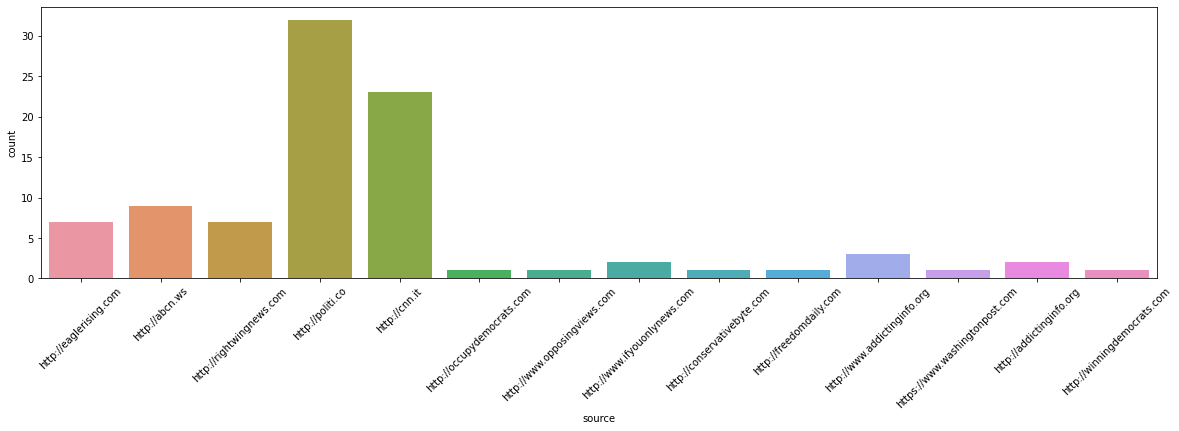

In [8]:
plt.figure(figsize=(20,5))
chart = sns.countplot("source", data=bfreal)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

In [9]:
#checking for rows with empty text
[index for index,text in enumerate(bfreal.text.values) if str(text).strip() == '']

[]

Adding class indication, and an empty subject column, prior to merging with Fake-and-real-news dataset.

In [10]:
bfreal["class"]=1
bfreal["subject"]=''
bfreal.head()

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data,class,subject
0,Real_1-Webpage,Another Terrorist Attack in NYC…Why Are we STI...,"On Saturday, September 17 at 8:30 pm EST, an e...",http://eaglerising.com/36942/another-terrorist...,http://eaglerising.com/wp-content/uploads/2016...,"View All Posts,Leonora Cravotta",http://eaglerising.com,{'$date': 1474528230000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36942/another-terrorist...,"{""description"": ""\u201cWe believe at this poin...",1,
1,Real_10-Webpage,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",Less than a day after protests over the police...,http://abcn.ws/2d4lNn9,http://a.abcnews.com/images/Politics/AP_donald...,"More Candace,Adam Kelsey,Abc News,More Adam",http://abcn.ws,NaN,NaN,http://www.googleadservices.com/pagead/convers...,http://abcnews.go.com/Politics/donald-trump-dr...,"{""fb_title"": ""Trump: Drugs a 'Very, Very Big F...",1,
2,Real_11-Webpage,"Obama To UN: ‘Giving Up Liberty, Enhances Secu...","Obama To UN: ‘Giving Up Liberty, Enhances Secu...",http://rightwingnews.com/barack-obama/obama-un...,http://rightwingnews.com/wp-content/uploads/20...,Cassy Fiano,http://rightwingnews.com,{'$date': 1474476044000},https://www.youtube.com/embed/ji6pl5Vwrvk,http://rightwingnews.com/wp-content/uploads/20...,http://rightwingnews.com/barack-obama/obama-un...,"{""googlebot"": ""noimageindex"", ""og"": {""site_nam...",1,
3,Real_12-Webpage,Trump vs. Clinton: A Fundamental Clash over Ho...,Getty Images Wealth Of Nations Trump vs. Clint...,http://politi.co/2de2qs0,http://static.politico.com/e9/11/6144cdc24e319...,"Jack Shafer,Erick Trickey,Zachary Karabell",http://politi.co,{'$date': 1474974420000},NaN,https://static.politico.com/dims4/default/8a1c...,http://www.politico.com/magazine/story/2016/09...,"{""description"": ""He sees it as zero-sum. She b...",1,
4,Real_13-Webpage,"President Obama Vetoes 9/11 Victims Bill, Sett...",President Obama today vetoed a bill that would...,http://abcn.ws/2dh2NFs,http://a.abcnews.com/images/US/AP_Obama_BM_201...,"John Parkinson,More John,Abc News,More Alexander",http://abcn.ws,NaN,NaN,http://www.googleadservices.com/pagead/convers...,http://abcnews.go.com/Politics/president-obama...,"{""fb_title"": ""President Obama Vetoes 9/11 Vict...",1,


Removing all polluting expressions in both text and title

In [0]:
#Seperating Publication info, from actual text
pollution_real = ["⋆ US Herald","– Eagle Rising", "The views expressed in this opinion article are solely those of their author and are not necessarily either shared or endorsed by EagleRising.com", " ⋆ Freedom Daily","Read More", "Authors:"]
for i in pollution_real:
    bfreal['title'] = bfreal['title'].str.replace(i , '')
    bfreal['text'] = bfreal['text'].str.replace(i , '')

## Integrating BuzzFeed Fake News

In [12]:
bffake = pd.read_csv('/content/drive/My Drive/CS221_Project/BuzzFeed_fake_news_content.csv')
bffake.shape

(91, 12)

In [13]:
bffake.head()

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data
0,Fake_1-Webpage,Proof The Mainstream Media Is Manipulating The...,I woke up this morning to find a variation of ...,http://www.addictinginfo.org/2016/09/19/proof-...,http://addictinginfo.addictinginfoent.netdna-c...,Wendy Gittleson,http://www.addictinginfo.org,{'$date': 1474243200000},NaN,"http://i.imgur.com/JeqZLhj.png,http://addictin...",http://addictinginfo.com/2016/09/19/proof-the-...,"{""publisher"": ""Addicting Info | The Knowledge ..."
1,Fake_10-Webpage,Charity: Clinton Foundation Distributed “Water...,Former President Bill Clinton and his Clinton ...,http://eaglerising.com/36899/charity-clinton-f...,http://eaglerising.com/wp-content/uploads/2016...,View All Posts,http://eaglerising.com,{'$date': 1474416521000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36899/charity-clinton-f...,"{""description"": ""The possibility that CHAI dis..."
2,Fake_11-Webpage,A Hillary Clinton Administration May be Entire...,After collapsing just before trying to step in...,http://eaglerising.com/36880/a-hillary-clinton...,http://eaglerising.com/wp-content/uploads/2016...,"View All Posts,Tony Elliott",http://eaglerising.com,{'$date': 1474416638000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36880/a-hillary-clinton...,"{""description"": ""Hillary Clinton may be the fi..."
3,Fake_12-Webpage,Trump’s Latest Campaign Promise May Be His Mos...,"Donald Trump is, well, deplorable. He’s sugges...",http://www.addictinginfo.org/2016/09/19/trumps...,http://addictinginfo.addictinginfoent.netdna-c...,John Prager,http://www.addictinginfo.org,{'$date': 1474243200000},NaN,"http://i.imgur.com/JeqZLhj.png,http://2.gravat...",http://addictinginfo.com/2016/09/19/trumps-lat...,"{""publisher"": ""Addicting Info | The Knowledge ..."
4,Fake_13-Webpage,Website is Down For Maintenance,Website is Down For Maintenance,http://www.proudcons.com/clinton-foundation-ca...,NaN,NaN,http://www.proudcons.com,NaN,NaN,NaN,NaN,"{""og"": {""url"": ""http://www.proudcons.com"", ""ty..."


In [14]:
bffake.describe()

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data
count,91,91,91,83,81,57,83,77,21,81,80,91
unique,91,87,87,80,79,30,22,69,21,79,78,81
top,Fake_26-Webpage,CNN’s Post-Debate Rigged Poll Busted…Here Are ...,After collapsing just before trying to step in...,http://eaglerising.com/36847/clinton-foundatio...,http://eaglerising.com/wp-content/uploads/2016...,Terresa Monroe-hamilton,http://rightwingnews.com,{'$date': 1474588800000},https://www.youtube.com/embed/x5IS6Ya005E?feat...,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36847/clinton-foundatio...,{}
freq,1,2,2,2,2,6,17,4,1,2,2,8


In [15]:
for key,count in bffake.source.value_counts().iteritems():
    print("{}:\t{}".format(key, count))
    
print("Total Records:\t{}".format(bffake.shape[0]))

http://rightwingnews.com:	17
http://freedomdaily.com:	16
http://eaglerising.com:	11
http://occupydemocrats.com:	6
https://goo.gl:	3
http://www.thepoliticalinsider.com:	3
http://www.addictinginfo.org:	3
http://allenwestrepublic.com:	2
http://clashdaily.com:	2
http://winningdemocrats.com:	2
http://100percentfedup.com:	2
https://ihavethetruth.com:	2
http://usherald.com:	2
http://theblacksphere.net:	2
http://www.proudcons.com:	2
http://conservativetribune.com:	2
http://author.addictinginfo.org:	1
http://author.groopspeak.com:	1
http://addictinginfo.org:	1
http://www.chicksontheright.com:	1
http://www.yesimright.com:	1
http://conservativebyte.com:	1
Total Records:	91


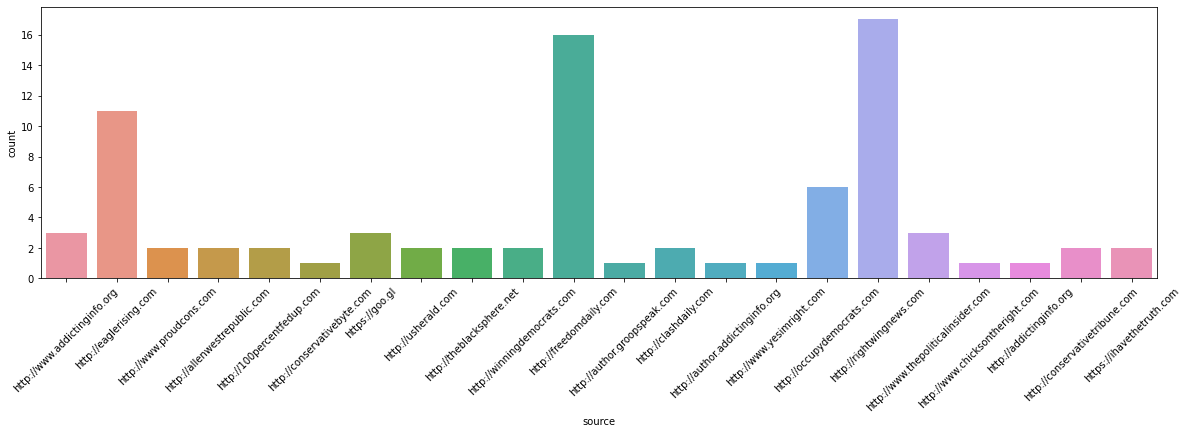

In [16]:
plt.figure(figsize=(20,5))
chart = sns.countplot("source", data=bffake)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

In [17]:
#checking for rows with empty text
[index for index,text in enumerate(bffake.text.values) if str(text).strip() == '']

[]

In [18]:
bffake["class"]=0
bffake["subject"]=''
bffake.head()

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data,class,subject
0,Fake_1-Webpage,Proof The Mainstream Media Is Manipulating The...,I woke up this morning to find a variation of ...,http://www.addictinginfo.org/2016/09/19/proof-...,http://addictinginfo.addictinginfoent.netdna-c...,Wendy Gittleson,http://www.addictinginfo.org,{'$date': 1474243200000},NaN,"http://i.imgur.com/JeqZLhj.png,http://addictin...",http://addictinginfo.com/2016/09/19/proof-the-...,"{""publisher"": ""Addicting Info | The Knowledge ...",0,
1,Fake_10-Webpage,Charity: Clinton Foundation Distributed “Water...,Former President Bill Clinton and his Clinton ...,http://eaglerising.com/36899/charity-clinton-f...,http://eaglerising.com/wp-content/uploads/2016...,View All Posts,http://eaglerising.com,{'$date': 1474416521000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36899/charity-clinton-f...,"{""description"": ""The possibility that CHAI dis...",0,
2,Fake_11-Webpage,A Hillary Clinton Administration May be Entire...,After collapsing just before trying to step in...,http://eaglerising.com/36880/a-hillary-clinton...,http://eaglerising.com/wp-content/uploads/2016...,"View All Posts,Tony Elliott",http://eaglerising.com,{'$date': 1474416638000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36880/a-hillary-clinton...,"{""description"": ""Hillary Clinton may be the fi...",0,
3,Fake_12-Webpage,Trump’s Latest Campaign Promise May Be His Mos...,"Donald Trump is, well, deplorable. He’s sugges...",http://www.addictinginfo.org/2016/09/19/trumps...,http://addictinginfo.addictinginfoent.netdna-c...,John Prager,http://www.addictinginfo.org,{'$date': 1474243200000},NaN,"http://i.imgur.com/JeqZLhj.png,http://2.gravat...",http://addictinginfo.com/2016/09/19/trumps-lat...,"{""publisher"": ""Addicting Info | The Knowledge ...",0,
4,Fake_13-Webpage,Website is Down For Maintenance,Website is Down For Maintenance,http://www.proudcons.com/clinton-foundation-ca...,NaN,NaN,http://www.proudcons.com,NaN,NaN,NaN,NaN,"{""og"": {""url"": ""http://www.proudcons.com"", ""ty...",0,


Removing all polluting expressions in both text and title

In [0]:
pollution_fake = ["⋆ US Herald","– Eagle Rising", "The views expressed in this opinion article are solely those of their author and are not necessarily either shared or endorsed by EagleRising.com", " ⋆ Freedom Daily","Read More", "Authors:"]
for i in pollution_fake:
    bffake['title'] = bffake['title'].str.replace(i , '')
    bffake['text'] = bffake['text'].str.replace(i , '')

## Integrating Fake-and-real-news Real News

In [20]:
reald = pd.read_csv('/content/drive/My Drive/CS221_Project/True.csv')
reald.shape

(21417, 4)

In [21]:
reald.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [22]:
for key,count in reald.subject.value_counts().iteritems():
    print("{}:\t{}".format(key, count))
    
print("Total Records:\t{}".format(reald.shape[0]))

politicsNews:	11272
worldnews:	10145
Total Records:	21417


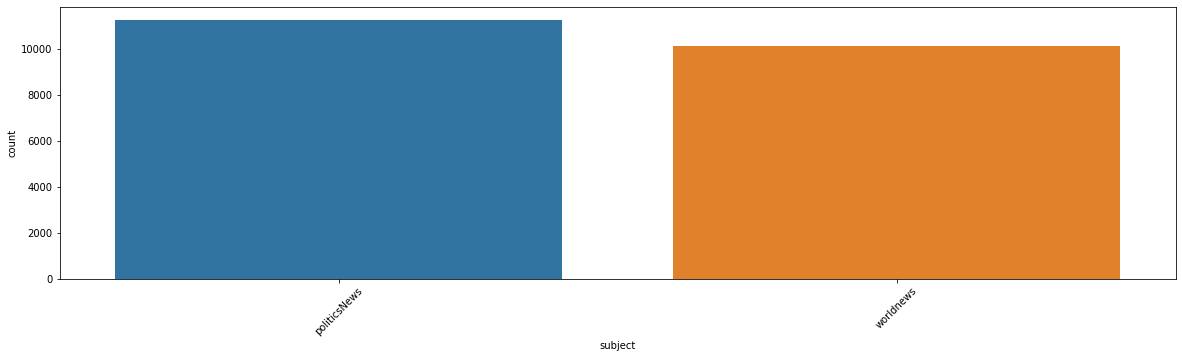

In [23]:
plt.figure(figsize=(20,5))
chart = sns.countplot("subject", data=reald)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

In [24]:
#First Creating list of index that do not have publication part
unknown_publishers = []
for index,row in enumerate(reald.text.values):
    try:
        record = row.split(" -", maxsplit=1)
        #if no text part is present, following will give error
        record[1]
        #if len of publication part is greater than 260
        #following will give error, ensuring no text having "-" in between is counted
        assert(len(record[0]) < 260)
    except:
        unknown_publishers.append(index)
#Thus we have list of indices where publisher is not mentioned
#lets check
reald.iloc[unknown_publishers].text

3488     The White House on Wednesday disclosed a group...
4358     Neil Gorsuch, President Donald Trump’s appoint...
4465     WASHINGTON The clock began running out this we...
5784     Federal appeals court judge Neil Gorsuch, the ...
6660     Republican members of Congress are complaining...
6823     Over the course of the U.S. presidential campa...
7922     After going through a week reminiscent of Napo...
8194     The following timeline charts the origin and s...
8195     Global health officials are racing to better u...
8247     U.S. President Barack Obama visited a street m...
8465     ALGONAC, MICH.—Parker Fox drifted out of the D...
8481     Global health officials are racing to better u...
8482     The following timeline charts the origin and s...
8505     Global health officials are racing to better u...
8506     The following timeline charts the origin and s...
8771     In a speech weighted with America’s complicate...
8970                                                    

In [25]:
#Seperating Publication info, from actual text
publisher = []
tmp_text = []
for idx,row in enumerate(reald.text.values):
    if idx in unknown_publishers:
        #Add unknown of publisher not mentioned
        tmp_text.append(row)
        publisher.append("Unknown")
        continue
    record = row.split(" -", maxsplit=1)
    publisher.append(record[0])
    tmp_text.append(record[1])

#Replace existing text column with new text
#add seperate column for publication info in case we want to use it later
reald["source"] = publisher
reald["text"] = tmp_text

del publisher, tmp_text, record, unknown_publishers
reald.head()

,title,text,subject,date,source
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [26]:
#checking for rows with empty text
[index for index,text in enumerate(reald.text.values) if str(text).strip() == '']

[8970]

In [0]:
#dropping this record
reald = reald.drop(8970, axis=0)

In [28]:
#renaming date column before merging with FakenewsNet dataset, and adding a class column
reald["class"]=1
reald = reald.rename(columns={"date":"publish_date"})
reald.head()

,title,text,subject,publish_date,source,class
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,politicsNews,"December 31, 2017",WASHINGTON (Reuters),1
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,politicsNews,"December 29, 2017",WASHINGTON (Reuters),1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,politicsNews,"December 31, 2017",WASHINGTON (Reuters),1
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,politicsNews,"December 30, 2017",WASHINGTON (Reuters),1
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters),1


## Integrating Fake-and-real-news Fake News

In [29]:
faked = pd.read_csv('/content/drive/My Drive/CS221_Project/Fake.csv')
faked.shape

(23481, 4)

In [30]:
faked.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [31]:
for key,count in faked.subject.value_counts().iteritems():
    print("{}:\t{}".format(key, count))
    
print("Total Records:\t{}".format(faked.shape[0]))

News:	9050
politics:	6841
left-news:	4459
Government News:	1570
US_News:	783
Middle-east:	778
Total Records:	23481


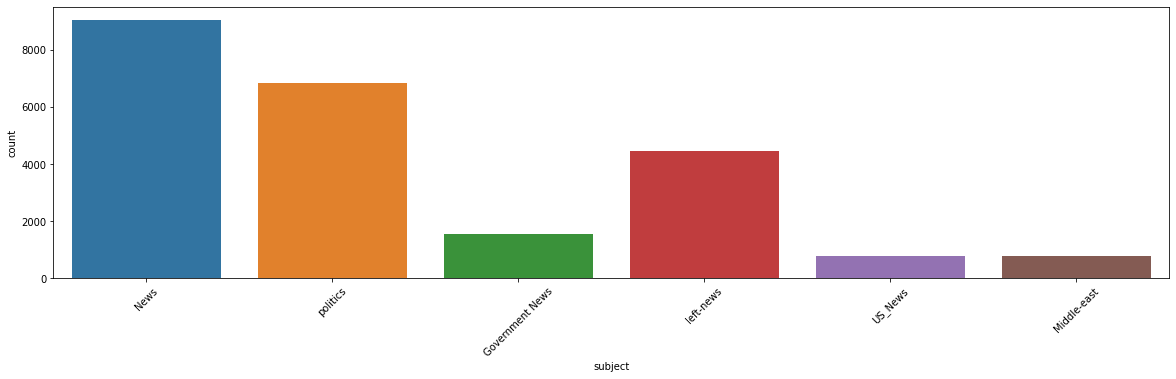

In [32]:
plt.figure(figsize=(20,5))
chart = sns.countplot("subject", data=faked)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

In [33]:
#checking for rows with empty text
empty_faked_index = [index for index,text in enumerate(faked.text.values) if str(text).strip() == '']
print("No of empty rows: {}".format(len(empty_faked_index)))
faked.iloc[empty_faked_index].tail()

No of empty rows: 630


,title,text,subject,date
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"
21873,(VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOU...,,left-news,"Apr 12, 2015"


In [34]:
#dropping this record
for i in empty_faked_index:
  faked = faked.drop(i, axis=0)

faked.shape

(22851, 4)

Removing polluting expressions in both title and text columns

In [0]:
pollution_faked = ["(VIDEO)", "Photo by", "/Getty Images", "Featured image", "pic.twitter.com"]
for i in pollution_faked:
    faked['title'] = faked['title'].str.replace(i , '')
    faked['text'] = faked['text'].str.replace(i , '')

In [36]:
#renaming date column before merging with FakenewsNet dataset, adding a class column and a source one set to "Unknown"
faked["class"]=0
faked["source"]="Unknown"
faked = faked.rename(columns={"date":"publish_date"})
faked.head()

,title,text,subject,publish_date,class,source
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0,Unknown
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0,Unknown
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0,Unknown
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0,Unknown
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0,Unknown


## Merging all 4 datasets into one

**Baseline**: merge title and text, and keep only the resulting value along with the class

In [37]:
bfreal_short = bfreal[["title", "text","class"]]
bfreal_short.head()

,title,text,class
0,Another Terrorist Attack in NYC…Why Are we STI...,"On Saturday, September 17 at 8:30 pm EST, an e...",1
1,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",Less than a day after protests over the police...,1
2,"Obama To UN: ‘Giving Up Liberty, Enhances Secu...","Obama To UN: ‘Giving Up Liberty, Enhances Secu...",1
3,Trump vs. Clinton: A Fundamental Clash over Ho...,Getty Images Wealth Of Nations Trump vs. Clint...,1
4,"President Obama Vetoes 9/11 Victims Bill, Sett...",President Obama today vetoed a bill that would...,1


In [38]:
bffake_short = bffake[["title", "text","class"]]
bffake_short.head()

,title,text,class
0,Proof The Mainstream Media Is Manipulating The...,I woke up this morning to find a variation of ...,0
1,Charity: Clinton Foundation Distributed “Water...,Former President Bill Clinton and his Clinton ...,0
2,A Hillary Clinton Administration May be Entire...,After collapsing just before trying to step in...,0
3,Trump’s Latest Campaign Promise May Be His Mos...,"Donald Trump is, well, deplorable. He’s sugges...",0
4,Website is Down For Maintenance,Website is Down For Maintenance,0


In [39]:
reald_short = reald[["title", "text","class"]]
reald_short.head()

,title,text,class
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,1
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,1
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,1
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,1


In [40]:
faked_short = faked[["title", "text","class"]]
faked_short.tail()

,title,text,class
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,0
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,0
23480,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,0


In [41]:
dataset = bfreal_short.append([bffake_short, reald_short, faked_short], ignore_index=True)
dataset.shape

(44449, 3)

In [42]:
#Combining Title and Text
dataset["text"] = dataset["title"] + " " + dataset["text"]
dataset = dataset.drop(["title"], axis=1)
dataset.head()

,text,class
0,Another Terrorist Attack in NYC…Why Are we STI...,1
1,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",1
2,"Obama To UN: ‘Giving Up Liberty, Enhances Secu...",1
3,Trump vs. Clinton: A Fundamental Clash over Ho...,1
4,"President Obama Vetoes 9/11 Victims Bill, Sett...",1


In [43]:
dataset.tail()

,text,class
44444,McPain: John McCain Furious That Iran Treated ...,0
44445,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,0
44446,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,0
44447,How to Blow $700 Million: Al Jazeera America F...,0
44448,10 U.S. Navy Sailors Held by Iranian Military ...,0


In [44]:
dataset.count()

text     44449
class    44449
dtype: int64

In [45]:
dataset["class"].value_counts()

0    22942
1    21507
Name: class, dtype: int64

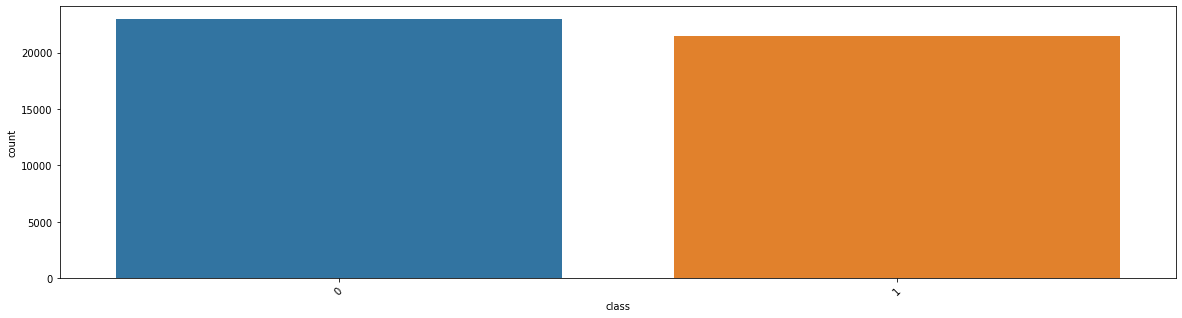

In [46]:
#Plotting total number of Fake and Real news
plt.figure(figsize=(20,5))
chart = sns.countplot("class", data=dataset)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

In [0]:
del bfreal, bfreal_short, bffake, bffake_short, reald, reald_short, faked, faked_short

# **Generating Oracle**

In [0]:
num_samples = 25
sampled = dataset.sample(n=num_samples)
sampled['text'].to_csv('/content/drive/My Drive/CS221_Project/oracle_data.csv', index=False)

After we've generated the file, we'd fill it out and then
run the following:

In [49]:
sampled = pd.read_csv('/content/drive/My Drive/CS221_Project/oracle_answers.csv')
guesses = pd.read_csv('/content/drive/My Drive/CS221_Project/oracle_data_filled_lowercase.csv')
guesses['roland'] = pd.to_numeric(guesses['roland'])
guesses['sathya'] = pd.to_numeric(guesses['sathya'])
accuracy = pd.DataFrame()
accuracy['roland'] = (sampled['class']==guesses['roland'])
accuracy['sathya'] = (sampled['class']==guesses['sathya'])
accuracy['max'] = (accuracy['sathya'] | accuracy['roland']) #picking the right answer if one of us chose it
accuracy['min'] = (accuracy['sathya'] & accuracy['roland']) #picking the wrong answer if one of us chose it
print("Roland accuracy: ", sum(accuracy['roland'])/num_samples)
print("Sathya accuracy: ", sum(accuracy['sathya'])/num_samples)
print("Maximum accuracy: ", sum(accuracy['max'])/num_samples)
print("Minimum accuracy: ", sum(accuracy['min'])/num_samples)

Roland accuracy:  0.52
Sathya accuracy:  0.52
Maximum accuracy:  0.56
Minimum accuracy:  0.48


# **Data Preprocessing**

Removing special sequences such as urls, emojis, etc. and optionally numbers

In [0]:
"""
A utility function to remove numerical characters from the text.

"""

def remove_nums(text):
    text = ''.join([i for i in text if not i.isdigit()])         
    return text


"""
A utility function to remove URL links from the text.

"""

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)


"""
A utility function to remove HTML tags from the text.

"""

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)


"""
A utility function to remove emojis from the text.

"""

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [0]:
#dataset["text"].apply(lambda x: remove_nums(x))
dataset['text'] = dataset["text"].apply(lambda x: remove_URL(x))
dataset['text'] = dataset["text"].apply(lambda x: remove_html(x))
dataset['text'] = dataset["text"].apply(lambda x: remove_emoji(x))

In [0]:
%%capture
#!pip install spellchecker
#!pip install indexer
#!pip install pyspellchecker

In [0]:
# OPTIONAL - VERY SLOW - Spelling correction

#from spellchecker import SpellChecker

#spell = SpellChecker()
#def correct_spellings(text):
#    corrected_text = []
#    misspelled_words = spell.unknown(text.split())
#    for word in text.split():
#        if word in misspelled_words:
#            corrected_text.append(spell.correction(word))
#        else:
#            corrected_text.append(word)
#    return " ".join(corrected_text)

#dataset["text"].apply(lambda text: correct_spellings(text))
#dataset.head(10)

Tokenization using NLTK, with cleaning of stopwords and punctuation

In [0]:
y = []
y = dataset["class"].values
#Converting X to format acceptable by gensim, removing stopwords and punctuation in the process
stop_words = set(nltk.corpus.stopwords.words("english"))
X = []
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in dataset["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

#del dataset

In [146]:
X[1][:10]

['donald',
 'trump',
 'drugs',
 'big',
 'factor',
 'charlotte',
 'protests',
 'less',
 'day',
 'protests']

In [147]:
#Confirming that X is a list of all news
len(X)

44449

In [148]:
#checking for rows with empty text
empty_X_lines = [index for index,text in enumerate(X) if text == []]
print(empty_X_lines)

[30956, 36727, 36728, 37030, 37031, 38550, 38551, 42838, 42839]


In [149]:
#Dropping those lines in both X and y
for i in reversed(empty_X_lines):
  del X[i]
  y = np.delete(y,i)

print(len(X), len(y))

44440 44440


In [150]:
#Identifying indexes of real and fake news
real_idx = [i for i,v in enumerate(y) if v == 1]
fake_idx = [i for i,v in enumerate(y) if v == 0]
print(len(real_idx), len(fake_idx))

21507 22933


In [60]:
X_real = []
X_fake = []
X_real = [X[i] for i in real_idx]
X_fake = [X[j] for j in fake_idx]
print(len(X_real), len(X_fake))

21507 22933


In [61]:
# OPTIONAL - Removing frequent and rare words from X_real

cnt_real = Counter()
for news in X_real:
  for word in news:
    cnt_real[word] += 1

n_rare_words = 10
RAREWORDS_real = set([w for (w, wc) in cnt_real.most_common()[:-n_rare_words-1:-1]])
        
FREQWORDS_real = set([w for (w, wc) in cnt_real.most_common(15)])

print('Rare words in Real dataset:', RAREWORDS_real)
print('Frequent words in Real dataset:', FREQWORDS_real)

Rare words in Real dataset: {'maksim', 'suhkoi', 'zhbankov', 'perdangangan', '1054', 'enggartiasto', 'perusahaan', 'hipster', 'lukita', 'belgazprombank'}
Frequent words in Real dataset: {'united', 'year', 'told', 'republican', 'would', 'new', 'president', 'states', 'trump', 'house', 'also', 'government', 'people', 'said', 'state'}


In [62]:
X_real_freq = []
tmp = []
for news in X_real:
  filtered_words = [w.strip() for w in news if w not in FREQWORDS_real and w not in RAREWORDS_real]
  tmp.append(filtered_words)
X_real_freq.extend(tmp)

X_real_freq[1][:10]

['donald',
 'drugs',
 'big',
 'factor',
 'charlotte',
 'protests',
 'less',
 'day',
 'protests',
 'police']

In [63]:
# OPTIONAL - Removing frequent and rare words from X_fake

cnt_fake = Counter()
for news in X_fake:
  for word in news:
    cnt_fake[word] += 1

n_rare_words = 10
RAREWORDS_fake = set([w for (w, wc) in cnt_fake.most_common()[:-n_rare_words-1:-1]])
        
FREQWORDS_fake = set([w for (w, wc) in cnt_fake.most_common(15)])

print('Rare words in Fake dataset:', RAREWORDS_fake)
print('Frequent words in Fake dataset:', FREQWORDS_fake)

Rare words in Fake dataset: {'glerup', 'betti', 'a4', 'ramification', 'treehousehere', 'barricading', 'j1', 'frenchglen', 'exemplifying', 'mondoweiss'}
Frequent words in Fake dataset: {'obama', 'would', 'new', 'president', 'donald', 'like', 'us', 'trump', 'people', 'also', 'one', 'news', 'said', 'clinton', 'hillary'}


In [64]:
X_fake_freq = []
tmp = []
for news in X_fake:
  filtered_words = [w.strip() for w in news if w not in FREQWORDS_fake and w not in RAREWORDS_fake]
  tmp.append(filtered_words)
X_fake_freq.extend(tmp)

X_fake_freq[1][:10]

['charity',
 'foundation',
 'distributed',
 'watered',
 'aids',
 'drugs',
 'sub',
 'saharan',
 'africa',
 'former']

In [65]:
#Recreating X with removed frequencies
X_freq = X_real_freq + X_fake_freq
y_freq = [1] * len(X_real_freq) + [0] * len(X_fake_freq)
print(len(X_freq), len(y_freq))

#Uncomment the following if you want to replace the original "X" to impact all following steps with removed frequencies
#X = []
#y = []
#X = X_freq
#y = y_freq
#X_real = []
#X_fake = []
#X_real = X_real_freq
#X_fake = X_fake_freq

44440 44440


In [66]:
#Ensuring that the word "Trump" has disappeared
X_freq[1][:10]

['donald',
 'drugs',
 'big',
 'factor',
 'charlotte',
 'protests',
 'less',
 'day',
 'protests',
 'police']

In [0]:
#put X back together and save as a CSV for input into BERT.
bert_dataset = []
for entry in X:
  bert_dataset.append(' '.join(entry))
bert_dataset = np.asarray(bert_dataset) 
bert_dataset = pd.DataFrame(data=bert_dataset, columns=["text"])
bert_dataset['class'] = dataset['class']

In [68]:
#bert_dataset.to_csv('/content/drive/My Drive/CS221_Project/dataset_reference.csv', index=False)
bert_dataset.head(10)

,text,class
0,another terrorist attack nyc still politically...,1
1,donald trump drugs big factor charlotte protes...,1
2,obama un giving liberty enhances security amer...,1
3,trump vs clinton fundamental clash economy wor...,1
4,president obama vetoes 11 victims bill setting...,1
5,chaos nc protest mob ambushes female truck dri...,1
6,10 moments mattered hillary clinton donald tru...,1
7,young girl emotional council speech laments sh...,1
8,jeb bush lecture harvard fall story highlights...,1
9,clinton vs trump debate debate hillary clinton...,1


In [0]:
# OPTIONAL - Lemmatization while respecting the POS

#from nltk.corpus import wordnet
#from nltk.stem import WordNetLemmatizer
#nltk.download('averaged_perceptron_tagger')

#lemmatizer = WordNetLemmatizer()
#wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
#def lemmatize_words(text):
#    pos_tagged_text = nltk.pos_tag(text.split())
#    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

#bert_dataset["text"].apply(lambda text: lemmatize_words(text))
#bert_dataset.head(10)

# **Data Analysis**

## Linguistic structure

(TODO) Compare real vs fake corpus via:


*   total #words, avg #words/news
*   total #unique words, avg #unique words/news, 
*   total #char per news, avg #char per news
*   total/avg unknown words? (due to abreviations, speaking language)
*   topics, avg # top words per topic (via LDA), dictionary differences
*   sentiment/emotion analysis
*   style analysis ?


In [0]:
dataset_real = bert_dataset.loc[dataset['class'] == 1]
dataset_fake = bert_dataset.loc[dataset['class'] == 0]

Total #words, avg #words/news

In [71]:
count_real = 0
for news in X_real:
    count_real += len(news)    

count_fake = 0
for news in X_fake:
    count_fake += len(news)    

print("Total number of words in real news: ",count_real)
print("Total number of words in fake news: ",count_fake)

Total number of words in real news:  5109437
Total number of words in fake news:  5863431


In [74]:
avg_real = []
for newsr in X_real:
    avg_real.append(len(newsr))

avg_fake = []
for newsf in X_fake:
    avg_fake.append(len(newsf))

print("Average number of words in real news: ",mean(avg_real))
print("Average number of words in fake news: ",mean(avg_fake))

Average number of words in real news:  237.5708838982657
Average number of words in fake news:  255.67657960144768


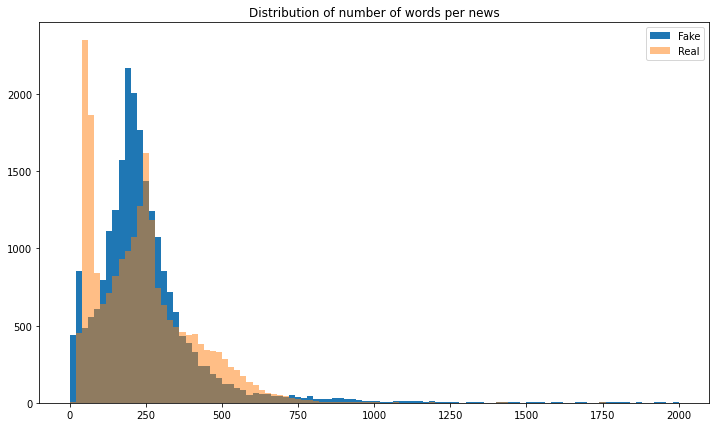

In [75]:
plt.figure(figsize = (12,7))
plt.hist(avg_fake, bins = 100, range = [0, 2000], label='Fake')
plt.hist(avg_real, bins = 100, range = [0, 2000], alpha=0.5, label='Real')
plt.legend(loc='upper right')
plt.title('Distribution of number of words per news')
plt.show()

In [76]:
#Five-numbers summary for each corpus 
def five_num_summary(dataframe):
    quartiles = np.percentile([len(x.split()) for x in dataframe["text"].tolist()], [0, 25, 50, 75, 100])
    
    return quartiles

true_summ = five_num_summary(dataset_real)

print("Text length - Five-number summary for true news:")
for i in range(0, 101,25):
    print("{}'th %ile: {}".format(i, int(true_summ[i//25])))
    
    
print("\n")


fake_summ = five_num_summary(dataset_fake)

print("Text length - Five-number summary for fake news:")
for i in range(0, 101,25):
    print("{}'th %ile: {}".format(i, int(fake_summ[i//25])))

Text length - Five-number summary for true news:
0'th %ile: 14
25'th %ile: 95
50'th %ile: 221
75'th %ile: 319
100'th %ile: 2879


Text length - Five-number summary for fake news:
0'th %ile: 4
25'th %ile: 154
50'th %ile: 215
75'th %ile: 296
100'th %ile: 5066


In [77]:
#Checking examples of the shortest fake news
X_fake_sorted = sorted(X_fake, key = len)
print(X_fake_sorted[:20])

[['website', 'maintenance', 'website', 'maintenance'], ['website', 'maintenance', 'website', 'maintenance'], ['judge', 'jeanine', 'gets', 'bottom', 'towergate', 'video'], ['think', 'dog', 'democrat', 'must', 'watch', 'video'], ['hillary', 'clinton', 'want', 'see', 'spread', 'everywhere'], ['think', 'dog', 'democrat', 'must', 'watch', 'video'], ['hillary', 'clinton', 'want', 'see', 'spread', 'everywhere'], ['favorite', 'excuses', 'featuring', 'hillary', 'rotten', 'clinton', 'enjoy'], ['hysterical', 'trump', 'said', 'reporter', 'president', 'read', 'wt'], ['breaking', 'trump', 'wrecks', 'dnc', 'video', 'absolutely', 'love'], ['hysterical', 'slap', 'msnbc', 'reporter', 'donald', 'trump', 'finished'], ['detroit', 'squatting', 'squatter', 'takes', 'turn', 'want', 'miss'], ['favorite', 'excuses', 'featuring', 'hillary', 'rotten', 'clinton', 'enjoy'], ['facts', 'slavery', 'democrats', 'want', 'know', 'spread', 'everywhere'], ['detroit', 'squatting', 'squatter', 'takes', 'turn', 'want', 'miss'

In [78]:
#Checking examples of the shortest real news
X_real_sorted = sorted(X_real, key = len)
print(X_real_sorted[:10])

[['factbox', 'trump', 'twitter', 'jan', '19', 'rev', 'graham', 'washington', 'inauguration', 'source', 'link', 'bit', 'ly', '2jbh4lu'], ['factbox', 'trump', 'twitter', 'feb', 'rex', 'tillerson', 'iran', 'australia', 'source', 'link', 'bit', 'ly', '2jbh4lu', 'bit', 'ly', '2jpexyr'], ['factbox', 'trump', 'twitter', 'jan', '25', 'abc', 'interview', 'voter', 'fraud', 'supreme', 'court', 'pick', 'source', 'link', 'bit', 'ly', '2jpy49u', 'bit', 'ly', '2jpexyr'], ['spain', 'cabinet', 'hold', 'special', 'meeting', '1700', 'gmt', 'spain', 'cabinet', 'hold', 'special', 'meeting', '1700', 'gmt', 'government', 'said', 'tuesday', 'without', 'giving', 'details'], ['putin', 'says', 'wants', 'constructive', 'relations', 'trump', 'russian', 'president', 'vladimir', 'putin', 'said', 'friday', 'wanted', 'constructive', 'relations', 'united', 'states', 'president', 'elect', 'donald', 'trump'], ['uk', 'pm', 'may', 'wants', 'strong', 'friend', 'eu', 'britain', 'wants', 'strong', 'friend', 'european', 'union

Total #unique words, avg #unique words/news

In [79]:
print("Total unique words in real news: ",len(cnt_real))
print("Total unique words in fake news: ",len(cnt_fake))

Total unique words in real news:  67162
Total unique words in fake news:  90846


Total #char per news, avg #char per news

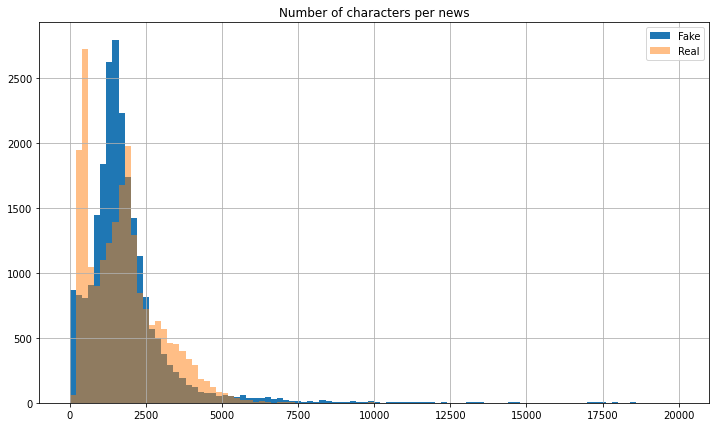

In [80]:
#Comparison of news lengths in characters number between Real and Fake news
plt.figure(figsize = (12,7))
dataset_fake['text'].str.len().hist(bins = 100, range = [0, 20000])
dataset_real['text'].str.len().hist(alpha=0.5, bins = 100, range = [0, 20000])
plt.title('Number of characters per news')
plt.legend(['Fake', 'Real'])
plt.show()

In [81]:
from statistics import mean
print("Real mean news length (in words #): ",mean(dataset_real['text'].str.len()))
print("Fake mean news length (in words #): ",mean(dataset_fake['text'].str.len()))

Real mean news length (in words #):  1767.099223508625
Fake mean news length (in words #):  1857.3968953037108


## Word Clouds

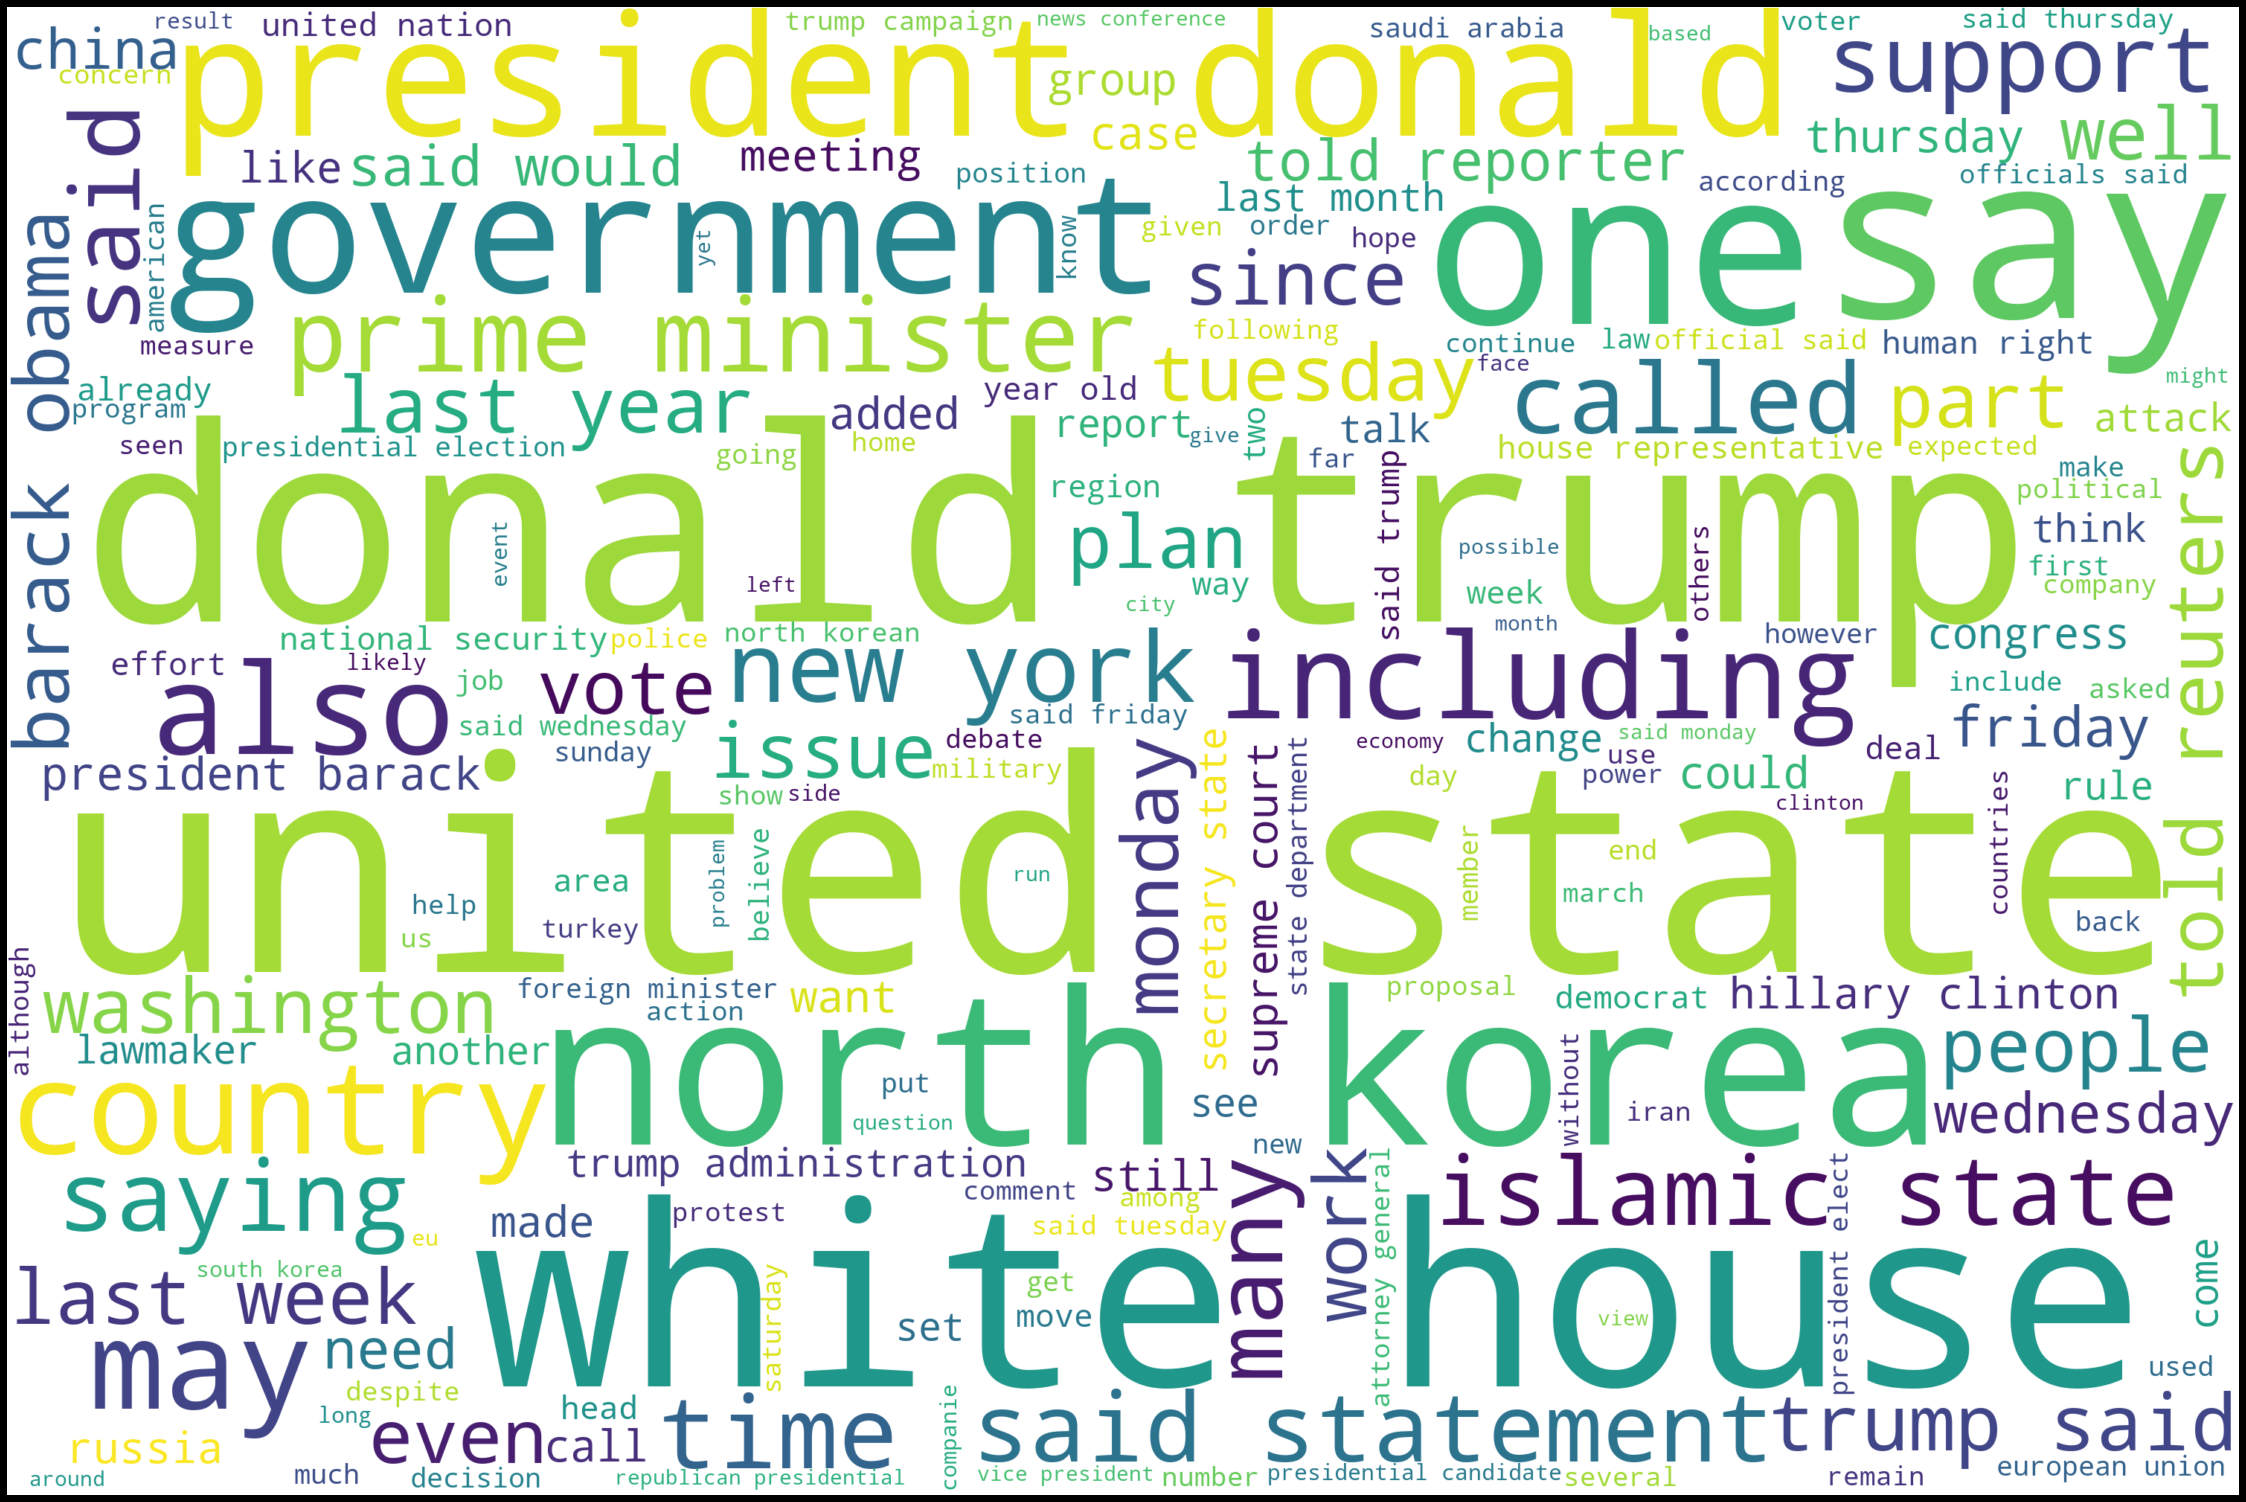

In [82]:
#Word Cloud on real news
text = ''
for news in dataset_real.text.values:
    text += news
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()
del text

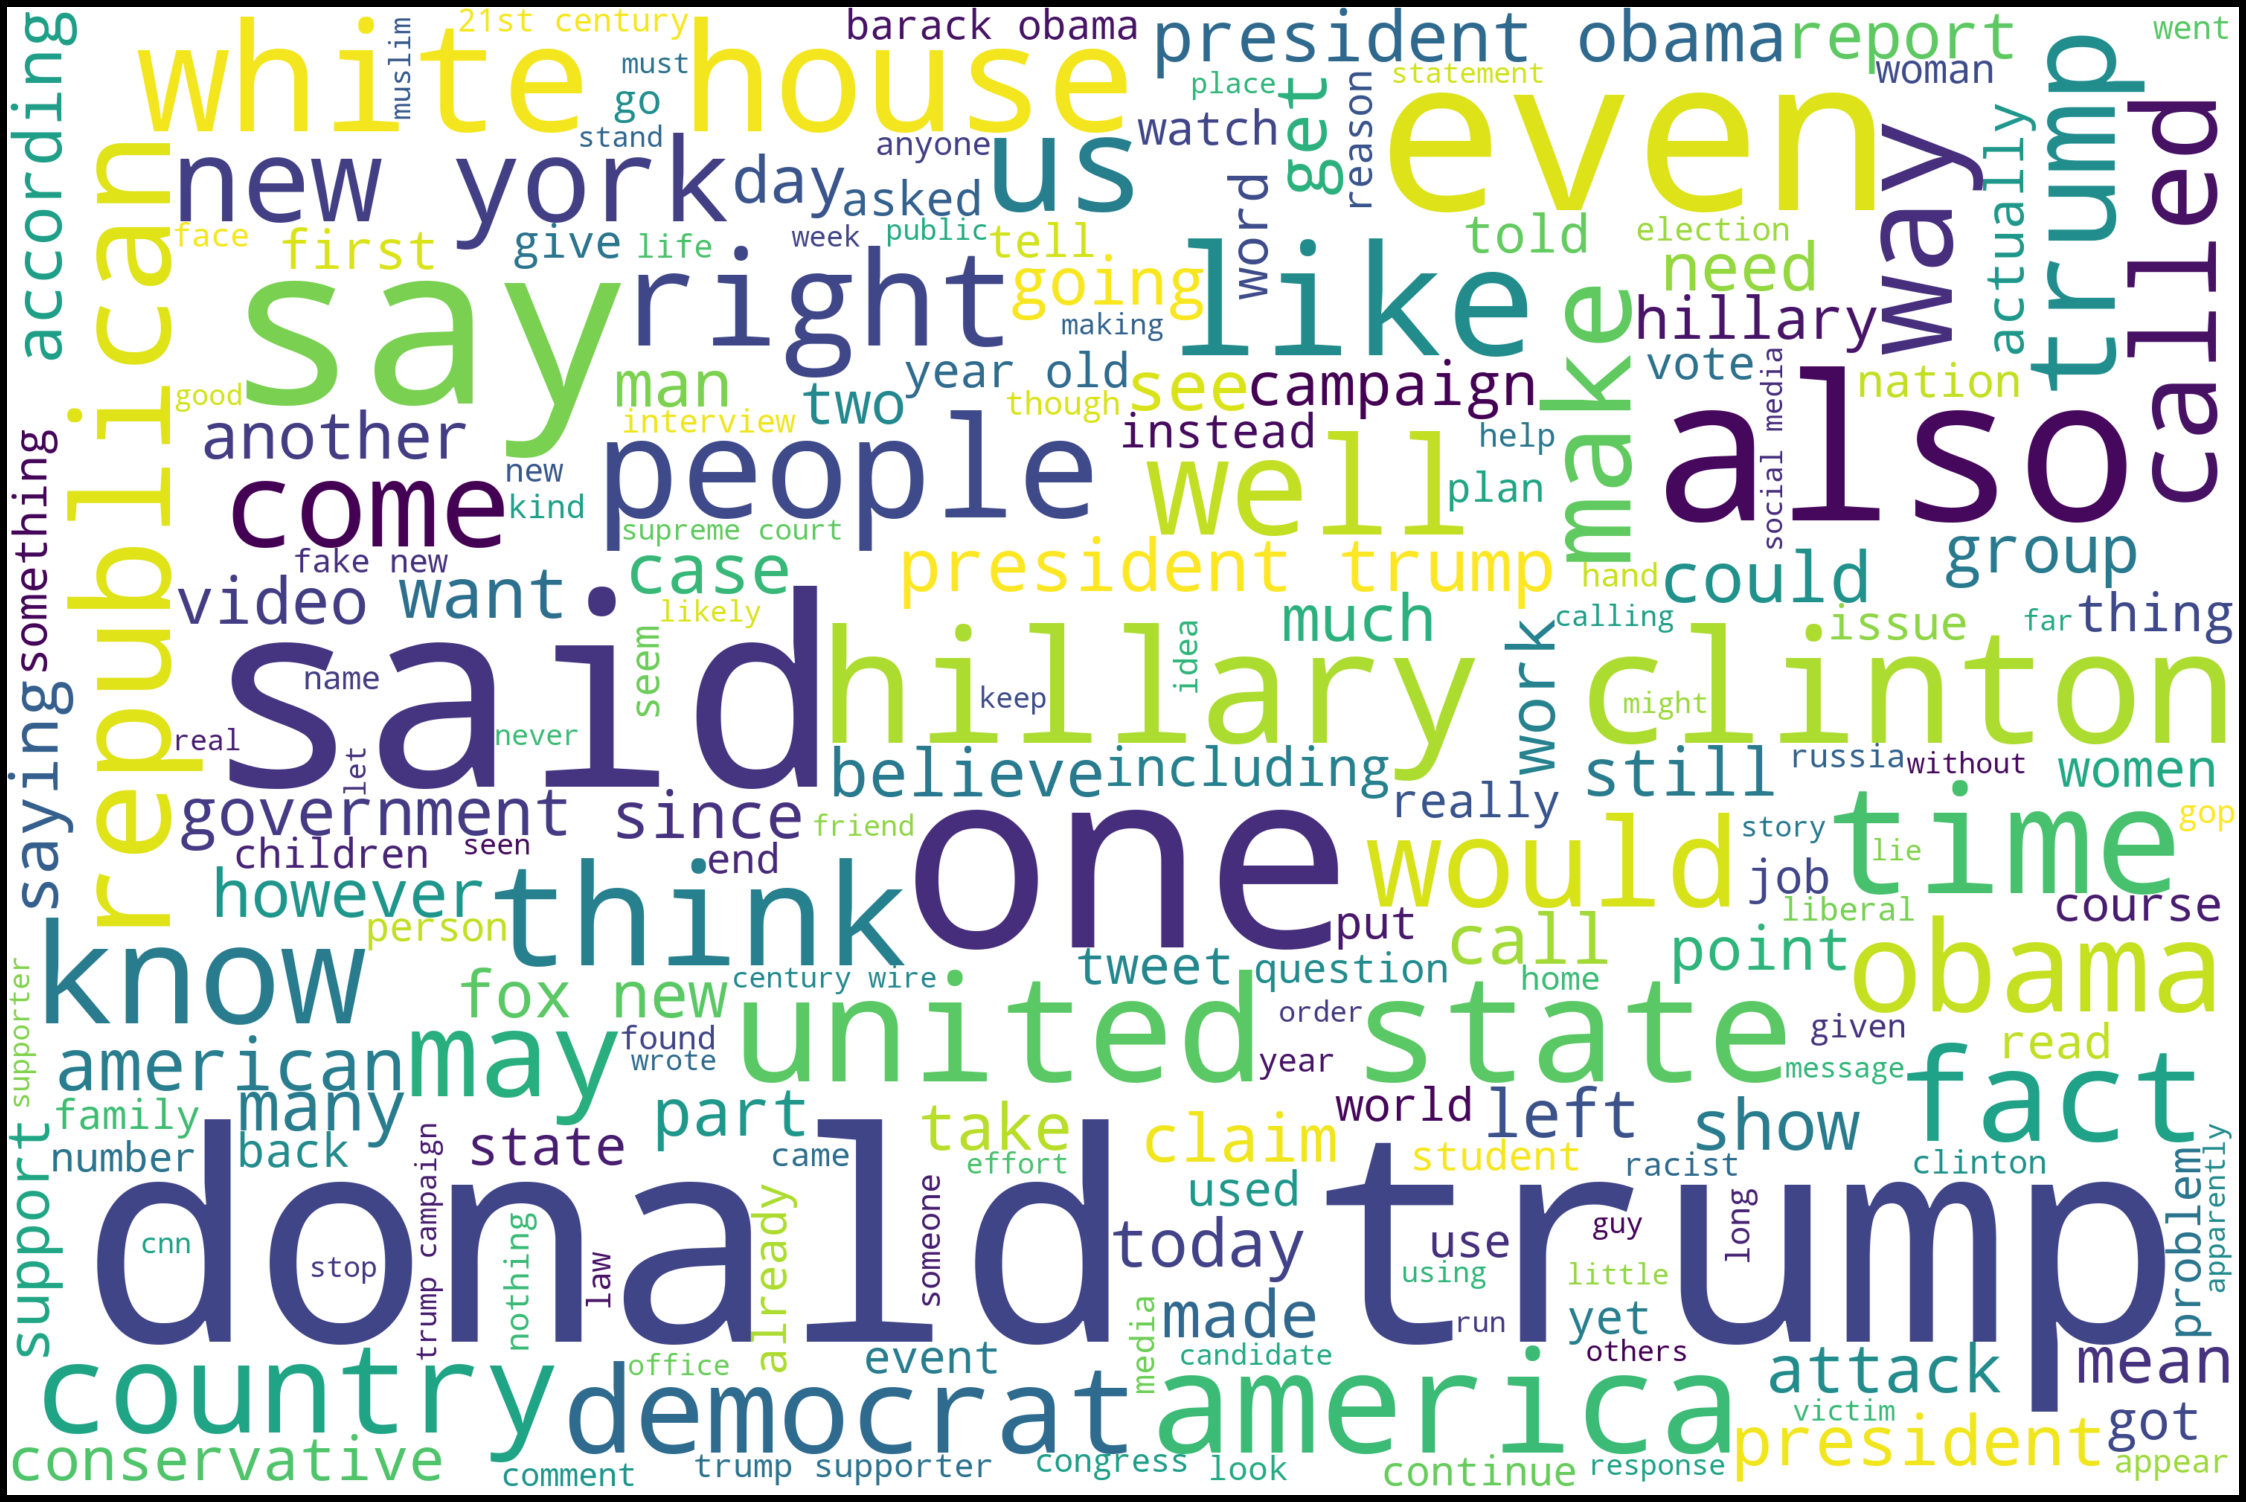

In [83]:
#Word Cloud on fake news
text = ''
for news in dataset_fake.text.values:
    text += news
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()
del text

## Words frequency

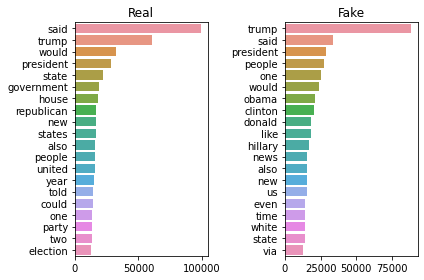

In [84]:
#Let's analyze most frequent words
corpus_real=[word for i in X_real for word in i]
counter_real=Counter(corpus_real)
most_real=counter_real.most_common()

x1, x2= [], []
for word,count in most_real[:40]:
    if (word not in stop_words and len(word) > 1):
        x1.append(word)
        x2.append(count)
 
corpus_fake=[word for j in X_fake for word in j]
counter_fake=Counter(corpus_fake)
most_fake=counter_fake.most_common()

x3, x4= [], []
for word,count in most_fake[:40]:
    if (word not in stop_words and len(word) > 1):
        x3.append(word)
        x4.append(count)

fig,(ax1, ax2) = plt.subplots(1,2)
sns.barplot(x=x2[:20],y=x1[:20],ax=ax1).set_title('Real')
sns.barplot(x=x4[:20],y=x3[:20],ax=ax2).set_title('Fake')
fig.tight_layout()

Bigrams and trigrams in both classes

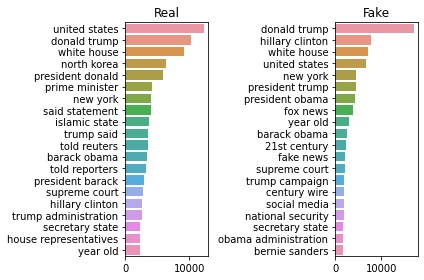

In [85]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(stop_words='english', lowercase=True, ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:20]

top_n_bigrams_real=get_top_ngram(dataset_real['text'],2)[:20]
x_,y_=map(list,zip(*top_n_bigrams_real))
top_n_bigrams_fake=get_top_ngram(dataset_fake['text'],2)[:20]
w_,z_=map(list,zip(*top_n_bigrams_fake))

fig,(ax1, ax2) = plt.subplots(1,2)
sns.barplot(x=y_,y=x_,ax=ax1).set_title('Real')
sns.barplot(x=z_,y=w_,ax=ax2).set_title('Fake')
fig.tight_layout()

## TF-IDF, k-means (to be continued)

In [0]:
#Alternative method of analyzing ngrams via TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
class NewTfidfVectorizer(TfidfVectorizer):
    def _word_ngrams(self, tokens, stop_words=None):

        # First get tokens without stop words
        tokens = super(TfidfVectorizer, self)._word_ngrams(tokens, None)
        if stop_words is not None:
            new_tokens=[]
            for token in tokens:
                split_words = token.split(' ')

                # Only check the first and last word for stop words
                if split_words[0] not in stop_words and split_words[-1] not in stop_words:
                    new_tokens.append(token)
            return new_tokens

        return tokens

vectorizer = NewTfidfVectorizer(stop_words='english', ngram_range=(3,3))
vectorizer.fit(bert_dataset["text"])

In [0]:
#K-means
#we can also pursue dimensionality reduction using LSA (I can write this code) if we want to improve further.
X_vec = vectorizer.fit_transform(bert_dataset['text'])
labels = bert_dataset['class']
true_k = np.unique(labels).shape[0]

km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,init_size=1000, 
                     batch_size=1000, verbose=False)
print("Clustering sparse data with %s" % km)
km.fit(X_vec)

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_vec, km.labels_, sample_size=1000))

print()

## Topic Modeling exploration with pyLDAvis

In [0]:
#Tokenization and lemmatization
from nltk.stem import PorterStemmer, WordNetLemmatizer

def preprocess_news(df):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for news in df['text']:
        words=[w for w in nltk.word_tokenize(news) if (w not in stop_words)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

corpus_real=preprocess_news(dataset_real)
corpus_fake=preprocess_news(dataset_fake)

In [0]:
#Let’s create the bag of words model using gensim
dic_real=gensim.corpora.Dictionary(corpus_real)
bow_corpus_real = [dic_real.doc2bow(doc_real) for doc_real in corpus_real]

dic_fake=gensim.corpora.Dictionary(corpus_fake)
bow_corpus_fake = [dic_fake.doc2bow(doc_fake) for doc_fake in corpus_fake]

In [0]:
#And finally create the LDA models
lda_model_real = gensim.models.LdaMulticore(bow_corpus_real, 
                                   num_topics = 4, 
                                   id2word = dic_real,                                    
                                   passes = 10,
                                   workers = 2)
lda_model_real.show_topics()

In [0]:
#And finally create the LDA models
lda_model_fake = gensim.models.LdaMulticore(bow_corpus_fake, 
                                   num_topics = 4, 
                                   id2word = dic_fake,                                    
                                   passes = 10,
                                   workers = 2)
lda_model_fake.show_topics()

In [0]:
%%capture
!pip install pyLDAvis

In [0]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis_real = pyLDAvis.gensim.prepare(lda_model_real, bow_corpus_real, dic_real)
vis_real

In [0]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis_fake = pyLDAvis.gensim.prepare(lda_model_fake, bow_corpus_fake, dic_fake)
vis_fake

## Readibility index (using Flesch reading ease score formula)

*   90-100 : Very Easy
*   80-89 : Easy
*   70-79 : Fairly Easy
*   60-69 : Standard
*   50-59 : Fairly Difficult
*   30-49 : Difficult
*   0-29 : Very Confusing

The formula for calculating the flesch reading easiness score is given below:

RE = 206.835 – (1.015 x ASL) – (84.6 x ASW)

RE = Readability Ease

ASL = Average Sentence Length (i.e., the number of words divided by the number of sentences)

ASW = Average number of syllables per word (i.e., the number of syllables divided by the number of words)

In [0]:
%%capture
!pip install textstat

In [0]:
#The analysis must be performed on the original dataset, before data preprocessing
import textstat as ts

real_news_readability = []
fake_news_readability = []

for sentence in dataset.loc[dataset['class'] == 1]["text"].tolist():
    temp = ts.flesch_reading_ease(sentence)
    real_news_readability.append(temp)
    
for sentence in dataset.loc[dataset['class'] == 0]["text"].tolist():
    temp = ts.flesch_reading_ease(sentence)
    fake_news_readability.append(temp)

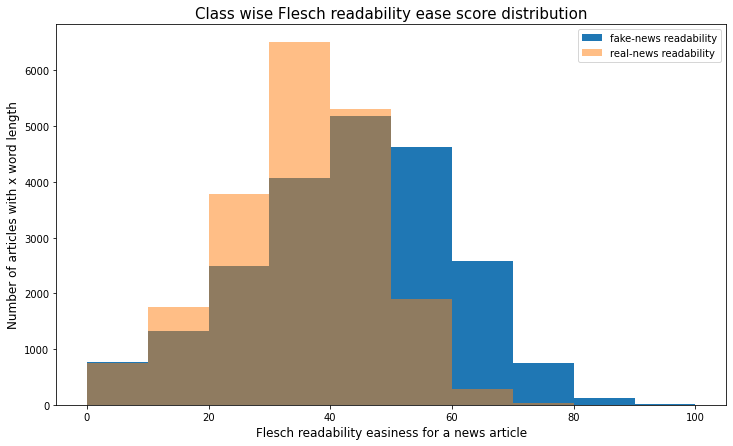

In [88]:
real_readability_df = pd.Series(real_news_readability)
fake_readability_df = pd.Series(fake_news_readability)

plt.figure(figsize = (12,7))
plt.hist(fake_readability_df, bins = 10, range = [0, 100], label = "fake-news readability")
plt.hist(real_readability_df, bins = 10, range = [0, 100], alpha = 0.5, label = "real-news readability")
plt.xlabel("Flesch readability easiness for a news article", fontsize = 12)
plt.ylabel("Number of articles with x word length", fontsize = 12)
plt.title("Class wise Flesch readability ease score distribution", fontsize = 15)
plt.legend()
plt.show()

## Sentiment analysis

In [90]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
vader = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [91]:
vader.polarity_scores('this is great work')

{'compound': 0.6249, 'neg': 0.0, 'neu': 0.423, 'pos': 0.577}

In [0]:
vader_real = []
dataset_scratch_real = dataset.loc[dataset['class'] == 1]["text"].tolist()

for i in range(len(dataset_scratch_real)):
  vader_real.append(vader.polarity_scores(str(dataset_scratch_real[i])))

In [109]:
pos = []
neg = []
neu = []
for j in range(len(vader_real)):
  pos.append(vader_real[j]['pos'])
  neg.append(vader_real[j]['neg'])
  neu.append(vader_real[j]['neu'])

print("Positive: ",sum(pos)/len(pos),"Neutral: ", sum(neu)/len(neu),"Negative :", sum(neg)/len(neg))

Positive:  0.0813450039522017 Neutral:  0.8397939275584646 Negative : 0.0788619519226298


In [0]:
vader_fake = []
dataset_scratch_fake = dataset.loc[dataset['class'] == 0]["text"].tolist()

for i in range(len(dataset_scratch_fake)):
  vader_fake.append(vader.polarity_scores(dataset_scratch_fake[i]))

In [107]:
pos_fake = []
neg_fake = []
neu_fake = []
for j in range(len(vader_real)):
  pos_fake.append(vader_real[j]['pos'])
  neg_fake.append(vader_real[j]['neg'])
  neu_fake.append(vader_real[j]['neu'])

print("Positive: ",sum(pos_fake)/len(pos_fake),"Neutral: ", sum(neu_fake)/len(neu_fake),"Negative :", sum(neg_fake)/len(neg_fake))

Positive:  0.0813450039522017 Neutral:  0.8397939275584646 Negative : 0.0788619519226298


# **Vectorization**

## Via TF-IDF

In [123]:
X_train = bert_dataset.loc[:38000, "text"].values
y_train = bert_dataset.loc[:38000, "class"].values
X_test = bert_dataset.loc[38000:, "text"].values
y_test = bert_dataset.loc[38000:, "class"].values
print(len(X_train), len(X_test))

38001 6440


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

## Via Word2Vec

In [0]:
#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

In [153]:
#vocab size
len(w2v_model.wv.vocab)

#We have now represented each of 122681 words by a 100dim vector.

118601

In [154]:
#see a sample vector for random word 
w2v_model["clinton"]

array([-2.8247945 ,  0.6787802 , -3.0067055 , -0.20453885,  0.08292702,
        0.04633988, -2.886924  ,  1.8924347 , -3.5481608 , -2.129358  ,
        0.2424494 ,  2.0197606 ,  1.194333  , -0.33709925,  0.06670116,
       -3.1487489 , -0.45915303,  0.8151115 ,  2.6785614 , -0.13120785,
       -1.4645785 ,  0.8681621 , -2.4546208 , -0.7725847 , -1.2067244 ,
       -2.7186947 , -2.6007628 ,  1.6024404 ,  2.2280216 ,  0.18269545,
       -0.02496897, -0.14720511,  1.1239743 ,  2.089499  , -0.27588105,
       -1.814351  , -3.5136817 ,  0.40789273,  1.4465666 ,  0.9506098 ,
        1.0669833 ,  1.017424  , -2.1798358 ,  0.8683211 ,  2.149665  ,
        1.494631  ,  0.26920703,  0.6597595 ,  0.08866594, -1.2148817 ,
        0.27330536, -4.320772  , -2.2905972 , -2.5052311 ,  3.9394643 ,
        1.992376  ,  0.6533846 , -1.972961  ,  1.5782804 , -1.6683309 ,
       -3.0825875 , -0.6913028 ,  2.4689429 , -0.01551125, -0.16329853,
       -0.7367279 ,  0.8127046 , -3.45224   ,  1.8330204 , -0.58

In [155]:
w2v_model.wv.most_similar("freedom")

[('freedoms', 0.6790018677711487),
 ('liberty', 0.6168991327285767),
 ('expression', 0.5752034187316895),
 ('free', 0.5567257404327393),
 ('democracy', 0.550133228302002),
 ('enshrined', 0.5263219475746155),
 ('exercising', 0.49851319193840027),
 ('gallups', 0.4944659471511841),
 ('protected', 0.48964786529541016),
 ('nonobjective', 0.4853828549385071)]

In [156]:
w2v_model.wv.most_similar("people")

[('folks', 0.6941046714782715),
 ('americans', 0.6631836891174316),
 ('citizens', 0.6312354803085327),
 ('adults', 0.5931945443153381),
 ('others', 0.5802731513977051),
 ('individuals', 0.5782903432846069),
 ('blacks', 0.5768575668334961),
 ('voters', 0.570602536201477),
 ('men', 0.5654754638671875),
 ('kids', 0.5618944764137268)]

In [0]:
# Tokenizing Text -> Repsesenting each word by a number
# Mapping of original word to number is preserved in word_index property of tokenizer

#Tokenizer applies basic processing like changing it to lower case, explicitely setting that as True even if already done before

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(X)

X_w2v = tokenizer.texts_to_sequences(X)

In [158]:
# lets check the first 10 words of first news
#every word has been represented with a number
X_w2v[0][:10]

[105, 636, 165, 3899, 102, 1676, 1864, 407, 522, 888]

In [159]:
#Lets check few word to numerical replesentation
#Mapping is preserved in dictionary -> word_index property of instance
word_index = tokenizer.word_index
for word, num in word_index.items():
    print("{} -> {}".format(word, num))
    if num == 10:
        break        

trump -> 1
said -> 2
president -> 3
would -> 4
people -> 5
one -> 6
state -> 7
new -> 8
obama -> 9
also -> 10


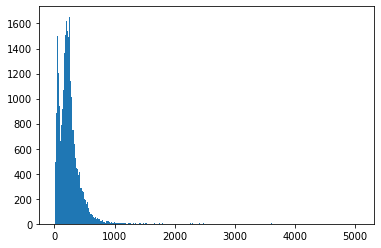

In [160]:
# Making histogram for no of words in news shows that most news article are under 700 words.
plt.hist([len(x) for x in X_w2v], bins=500)
plt.show()

In [161]:
# Most of the news have less than 700 words
nos = np.array([len(x) for x in X_w2v])
print(len(nos[nos  < 700])/len(X_w2v))

0.9792079207920792


In [0]:
#Lets keep all news to 700, add padding to news with less than 700 words and truncating long ones
maxlen = 700 

#Making all news of size maxlen defined above, padding with 0 when needed
X_w2v = pad_sequences(X_w2v, maxlen=maxlen)

In [163]:
#Checking
len(X_w2v[0])

700

In [0]:
#Saving this tokenized and vectorized version to file
with open('/content/drive/My Drive/CS221_Project/X_w2v_tok.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(X_w2v)

In [0]:
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, y, test_size = 0.15) 

# **Modelization** 

## Naïve Bayes model

On TF-IDF vectorized input

In [0]:
from sklearn.naive_bayes import MultinomialNB

naive_bayes_model = MultinomialNB().fit(X_train_tfidf,y_train)

In [126]:
#Model Evaluation
predictions = naive_bayes_model.predict(X_test_tfidf)
print(predictions)

[0 0 0 ... 1 0 1]


In [127]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89      6440
           1       0.00      0.00      0.00         0

    accuracy                           0.80      6440
   macro avg       0.50      0.40      0.44      6440
weighted avg       1.00      0.80      0.89      6440



On W2V vectorized input

In [0]:
naive_bayes_model_w2v = MultinomialNB().fit(X_train_w2v,y_train_w2v)

In [167]:
predictions_nb_w2v = naive_bayes_model_w2v.predict(X_test_w2v)
print(classification_report(y_test_w2v, predictions_nb_w2v))

              precision    recall  f1-score   support

           0       0.60      0.74      0.66      3394
           1       0.64      0.48      0.55      3272

    accuracy                           0.61      6666
   macro avg       0.62      0.61      0.61      6666
weighted avg       0.62      0.61      0.61      6666



## Support Vector Machine

On TF-IDF vectorized input

In [0]:
from sklearn.svm import SVC

linear_svm_classifier_tfidf = SVC(kernel = "linear").fit(X_train_tfidf,y_train)

In [0]:
#Model Evaluation
predictions_svm_tfidf = linear_svm_classifier_tfidf.predict(X_test_tfidf)
print(predictions_svm_tfidf)

In [0]:
print(classification_report(y_test, predictions_svm_tfidf))

On W2V vectorized input

In [0]:
linear_svm_classifier_w2v = SVC(kernel = "linear").fit(X_train_w2v, y_train_w2v)

In [0]:
predictions_svm_w2v = linear_svm_classifier_w2v.predict(X_test_w2v)
print(classification_report(y_test_w2v, predictions_svm_w2v))

## Simple Neural Network

In [0]:
# Embedding Layer used in Keras creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [0]:
# Function to create weight matrix between word-index and vectors from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [0]:
#Getting embedding vectors from word2vec and using it as weights of non-trainable keras embedding layer
#This embedding layer accepts numerical-token of word and outputs corresponding vector to inner layer.
#It sends vector of zeros to next layer for unknown words which would be tokenized to 0.
#Input length of embedding Layer is the length of each news (700 now due to padding and truncating)
%%capture
#del embedding_vectors
embedding_vectors = get_weight_matrix(w2v_model, word_index)

In [0]:
dnn_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
dnn_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [0]:
early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

dnn_history = dnn_model.fit(X_train_w2v, y_train_w2v, epochs=num_epochs, validation_split = 0.2, \
                        callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

In [0]:
plt.plot(dnn_history.history['loss'])
plt.plot(dnn_history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [0]:
dnn_results = dnn_model.evaluate(X_test_w2v, y_test_w2v, batch_size=128)

print('Regular dense network - test loss: {}'.format(dnn_results[0]))
print('Regular dense network - test accuracy: {}'.format(dnn_results[1]))

In [0]:
dnn_pred = (dnn_model.predict(X_test_w2v) >= 0.5).astype("int")

print("A detailed report on the model performance:")

print("Model type: Regular dense neural network.")
print(classification_report(y_test_w2v, dnn_pred))

## Many to one LSTM

In [0]:
#Defining Neural Network
lstm_model = Sequential()
#Non-trainable embeddidng layer
lstm_model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
lstm_model.add(LSTM(units=128))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

#del embedding_vectors

In [0]:
lstm_model.summary()

In [0]:
early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

history = lstm_model.fit(X_train_w2v, y_train_w2v, validation_split=0.3, epochs=4, \
                         callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [0]:
#Prediction is in probability of news being real, so converting into classes
y_pred = (lstm_model.predict(X_test_w2v) >= 0.5).astype("int")

In [0]:
print(classification_report(y_test_w2v, y_pred))

## Bert 

Leveraging work from [this colab](https://colab.sandbox.google.com/drive/1W8yYgQJ6AAvwZ3AdfuPDLirqXOtHbmuO#scrollTo=6o2a5ZIvRcJq)

In [0]:
!pip install bert-tensorflow

In [0]:
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

In [0]:
# Set the output directory for saving model file
# Optionally, set a GCP bucket location

OUTPUT_DIR = 'model_out'#@param {type:"string"}
#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = False #@param {type:"boolean"}
#@markdown Set USE_BUCKET and BUCKET if you want to (optionally) store model output on GCP bucket.
USE_BUCKET = False #@param {type:"boolean"}
BUCKET = 'BUCKET_NAME' #@param {type:"string"}

if USE_BUCKET:
  OUTPUT_DIR = 'gs://{}/{}'.format(BUCKET, OUTPUT_DIR)
  from google.colab import auth
  auth.authenticate_user()

if DO_DELETE:
  try:
    tf.gfile.DeleteRecursively(OUTPUT_DIR)
  except:
    # Doesn't matter if the directory didn't exist
    pass
tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))


In [0]:
#Import dataset file if not done already
dataset_processed = pd.read_csv('/content/drive/My Drive/CS221_Project/dataset_reference.csv')

In [0]:
train_df = dataset_processed.sample(frac=0.7, replace=False, random_state=1)
val_df = dataset_processed.sample(frac=0.15, replace=False, random_state=1)
test_df = dataset_processed.sample(frac=0.15, replace=False, random_state=1)
print(train_df.shape, val_df.shape, test_df.shape)

In [0]:
# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = train_df.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x['text'], 
                                                                   text_b = None, 
                                                                   label = x['class']), axis = 1)

dev_InputExamples = val_df.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x['text'], 
                                                                   text_b = None, 
                                                                   label = x['class']), axis = 1)

test_InputExamples = test_df.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x['text'], 
                                                                   text_b = None, 
                                                                   label = x['class']), axis = 1)

In [0]:
# In order to preprocess the data, we'll load a vocabulary file and lowercasing information directly from the BERT tf hub module
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer_bert = create_tokenizer_from_hub_module()

In [0]:
tokenizer_bert.tokenize("betsy devos gets skewered after dept. of education posts embarrassingly misspelled tweets donald trump s education department is pathetic now that betsy devos is in control, and this proves it.devos first week as secretary of education has been terrible to say the least.first, she was blocked from entering a public school by protesters and ran away. then she posted a tweet jokingly asking where the pencils are, which drew a sharp rebuke from teachers, who did not find her joke funny because they usually have to buy their own school supplies for their classrooms.and so, the department of education under devos rule is off to a rough start, and it got downright embarrassing on sunday as americans watched in horror as the education department proceeded to post twitter messages containing misspelled words.seriously. this is the f*cking department of education we are talking about. spelling should be in their wheelhouse. but because of trump and devos, that skill has apparently been lost.in celebration of black history month, the department of education decided to recognize and quote w.e.b. du bois. it did not go well.education must not simply teach work it must teach life. w.e.b. debois /re4cwkpsfa us dept of education (@usedgov) february 12, 2017that s right. devos and her team actually misspelled du bois name. and mockery and outrage rained down upon them for it.welp, this is a foreshadowing of what #betsydevos is going to usher in @usedgov. ffs! it s #blackhistorymonth too!??w. e. b. du bois?? /qkhyauyp6i khary penebaker (@kharyp) february 12, 2017@usedgov looks like @betsydevos is in charge now! /paajszsusl mike flacy (@mikeflacy) february 12, 2017.@usedgov *w.e.b. du boisall good. not like this is the official twitter for the us department of education. ? ryan wyatt (@fwiz) february 12, 2017@usedgov i am glad my public school teachers taught me how to properly spell the names of noted scholars!! maris kreizman (@mariskreizman) february 12, 2017@usedgov omg, it s dubois. who is in charge over there? oh, wait, i get it. jennifer morgan (@profjlmorgan) february 12, 2017.@usedgov first y all thought frederick douglass was alive, now you can t spell du bois. this bodes well for an already faltering system. mehreen kasana (@mehreenkasana) february 12, 2017hilarious, @usedgov. it s either a terrible mistake or a perverse foray into humor. his name is w.e.b. du bois. screenshot saved. /dfdv887rne jeffrey guterman (@jeffreyguterman) february 12, 2017@jeffreyguterman @usedgov is @betsydevos in charge of social media content too? was she distracted by a grizzly? ? @pc7 (@pjcc777) february 12, 2017@usedgov how the hell do you misspell his name? if this isn t foreshadowing the shitstorm of #betsydevos, then i don t know what is s vion (@savionwright) february 12, 2017i see they left ms. duvos in charge of the @usedgov twitter feed /sw0scgm49u jason tocci (@jasont) february 12, 2017protesters should ve let @betsydevos into the school long enough to learn how to spell his name correctly @usedgovhttps://t.co/pdzsgu5xev carlton banksy (@rtyson82) february 12, 2017and if that wasn t enough, the department of education posted a corrected version and then posted an apology tweet that was also misspelled.again, seriously. education must not simply teach work it must teach life. w.e.b. du bois /hsg4r1rlhh us dept of education (@usedgov) february 12, 2017 our deepest apologizes /0staogo3fd josh billinson (@jbillinson) february 12, 2017even reading rainbow star levar burton chimed in.heaven help us! the dept. of education misspelled dubois #bydhttmwfi https://t.co/pt6i1em8an levar burton (@levarburton) february 12, 2017betsy devos hasn t even been in charge for a full week and she has already repeatedly proved that while money can buy a cabinet seat, in her case it could not buy a decent education. via chip somodevilla")

In [0]:
# label_list is the list of labels, i.e. True, False or 0, 1
label_list = [True, False]

In [0]:
# We'll set sequences to be at most 128 tokens long (due to memory restriction)
MAX_SEQ_LENGTH = 128
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer_bert)
dev_features = bert.run_classifier.convert_examples_to_features(dev_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer_bert)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer_bert)

In [0]:
#Creating our model by fine-tuning Bert module
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  """Creates a classification model."""

  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [0]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        f1_score = tf.contrib.metrics.f1_score(
            label_ids,
            predicted_labels)
        auc = tf.metrics.auc(
            label_ids,
            predicted_labels)
        recall = tf.metrics.recall(
            label_ids,
            predicted_labels)
        precision = tf.metrics.precision(
            label_ids,
            predicted_labels) 
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        return {
            "eval_accuracy": accuracy,
            "f1_score": f1_score,
            "auc": auc,
            "precision": precision,
            "recall": recall,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg,
        }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn


In [0]:
# Compute train and warmup steps from batch size
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where the learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

In [0]:
# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [0]:
# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [0]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})


In [0]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

In [0]:
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

In [0]:
dev_input_fn = run_classifier.input_fn_builder(
    features=dev_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [0]:
estimator.evaluate(input_fn=dev_input_fn, steps=None)

In [0]:
test_input_fn = run_classifier.input_fn_builder(features=test_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
estimator.evaluate(input_fn=test_input_fn, steps=None)

In [0]:
#Preparing predictions on new articles
def getPrediction(in_news):
  labels = ["Real", "Fake"]
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_news] # here, "" is just a dummy label
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer_bert)
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  return [(prediction['probabilities'], labels[prediction['labels']]) for prediction in predictions]

In [0]:
pred_news = []
pred_labels = []
with open('/content/drive/My Drive/CS221_Project/pred_news.csv', newline='') as f:
    reader = csv.reader(f)
    for row in reader:
      pred_news.append(row[0])
      pred_labels.append(row[1])

In [0]:
print(pred_labels)

In [0]:
predictions = getPrediction(pred_news)

In [0]:
predictions